refer to https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

to tune parameters
refer to http://yangguang2009.github.io/2017/01/08/deeplearning/grid-search-hyperparameters-for-deep-learning/

In [1]:
from __future__ import print_function


import json
import numpy as np
import os
import pandas as pd
import urllib
import math

from pandas import read_csv
from pandas import DataFrame
from pandas import concat

'''
# connect to poloniex's API
url = 'https://poloniex.com/public?command=returnChartData&currencyPair=USDT_BTC&start=1546300800&end=9999999999&period=300&resolution=auto'

# parse json returned from the API to Pandas DF
openUrl = urllib.request.urlopen(url)
r = openUrl.read()
openUrl.close()
d = json.loads(r.decode())
df = pd.DataFrame(d)

original_columns=[u'date', u'close',  u'high', u'low', u'open', u'volume']
new_columns = ['Timestamp','Close','High','Low','Open','Volume']
df = df.loc[:,original_columns]
df.columns = new_columns
df.to_csv('bitcoin201901to201905.csv',index=None)

df = df.set_index('Timestamp')
df.head()
'''

"\n# connect to poloniex's API\nurl = 'https://poloniex.com/public?command=returnChartData&currencyPair=USDT_BTC&start=1546300800&end=9999999999&period=300&resolution=auto'\n\n# parse json returned from the API to Pandas DF\nopenUrl = urllib.request.urlopen(url)\nr = openUrl.read()\nopenUrl.close()\nd = json.loads(r.decode())\ndf = pd.DataFrame(d)\n\noriginal_columns=[u'date', u'close',  u'high', u'low', u'open', u'volume']\nnew_columns = ['Timestamp','Close','High','Low','Open','Volume']\ndf = df.loc[:,original_columns]\ndf.columns = new_columns\ndf.to_csv('bitcoin201901to201905.csv',index=None)\n\ndf = df.set_index('Timestamp')\ndf.head()\n"

In [2]:
# dataset from poloniex.com
df = read_csv('bitcoin201901to201905.csv', header=0, index_col=0)
values = df.values

df.head()

,Close,High,Low,Open,Volume
Timestamp,,,,,
1546300800,3697.730000,3700.0000,3691.000002,3696.202300,7095.559257
1546301700,3695.179141,3697.9878,3687.024301,3694.186356,2142.803493
1546302600,3703.000000,3707.7001,3697.897800,3697.957800,15972.302727
1546303500,3703.000000,3711.4200,3703.000000,3703.000044,5796.233350
1546304400,3691.603671,3709.9000,3691.603671,3697.977800,1297.983519


In [3]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import seaborn as sns
import numpy as np
 
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

Using TensorFlow backend.


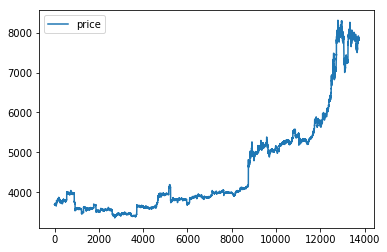

In [4]:
pyplot.plot(df['Close'].values, label='price')
pyplot.legend()
pyplot.show()

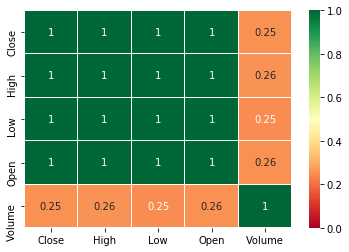

In [5]:
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn', linewidths=0.1, vmin=0)

In [6]:

# load dataset
#dataset = read_csv('update_20190301_bitbank_f.csv', header=0, index_col=0)
#values = dataset.values

#dataset.head()

values = df['Close'].values
values = values.reshape(-1, 1)
print(values)

[[3697.72999999]
 [3695.17914064]
 [3703.        ]
 ...
 [7823.31328444]
 [7825.63875318]
 [7813.8185756 ]]


In [7]:

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

#test =  series_to_supervised(values, 1, 1)
#print(test.head())
#print(test.shape)


In [8]:
reframed.head()

,var1(t-1),var1(t)
1,0.068520,0.068006
2,0.068006,0.069584
3,0.069584,0.069584
4,0.069584,0.067284
5,0.067284,0.069181


In [9]:
import math

# drop columns we don't want to predict
# 只留下 close 列
#reframed.drop(reframed.columns[[6, 7, 8, 10, 11]], axis=1, inplace=True)
#print(reframed.head())
 
# split into train and test sets
values = reframed.values
print(values.shape)

batch_size=32

n_train_rate = 0.9
n_train = int(values.shape[0] * n_train_rate)
#n_train = math.floor(n_train)
n_train -= n_train % batch_size
print(n_train)

train = values[:n_train, :]
test = values[n_train:, :]

# tweak to match with batch_size
to_drop = values.shape[0] % batch_size
if to_drop > 0:
    test = test[:-1 * to_drop]        

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(13747, 2)
12352
(12352, 1, 1) (12352,) (1376, 1, 1) (1376,)


In [10]:
#!pip install tqdm --upgrade
#!pip install hyperopt --upgrade
#!pip install hyperas --upgrade
#!pip install talos

In [11]:
print(train_X[0])

#import talos
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


epoch = 10

'''
# design network
def myModel(train_X, train_y, test_X, test_y, params):
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=False))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    # fit network
    out = model.fit(train_X, train_y, epochs=params['epochs'], batch_size=params['batch_size'], validation_data=(test_X, test_y), verbose=2, shuffle=False)
    return out, model

model = talos.Scan(train_X, train_y, params=p, model=myModel)
'''

model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]), batch_size=batch_size,
               return_sequences=False, stateful=True))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
    # fit network
history = model.fit(train_X, train_y, epochs=epoch, batch_size=batch_size, validation_data=(test_X, test_y), verbose=1, shuffle=False)
#'''
'''
def create_model():
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=False))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    return model

model=KerasRegressor(build_fn=create_model, epochs=10, verbose=1)


p = {
    'epochs': [10, 25, 50],
    'batch_size': [16, 32, 50]
}

param_grid = {
#    'clf__neurons_input':   [20, 25, 30, 35],
    'batch_size': [40,60,80], 
    'epochs': [10, 25, 50]
#    'clf__optimizer': ['Adam', 'Adadelta']
}

grid = GridSearchCV(estimator=model, param_grid=p, scoring='neg_mean_squared_error',
                               verbose=3,n_jobs=1)

    # fit network
#history = model.fit(train_X, train_y, epochs=50, batch_size=50, validation_data=(test_X, test_y), verbose=2, shuffle=False)

grid.fit(train_X, train_y, validation_data=(test_X, test_y), verbose=2, shuffle=False)
'''


[[0.06852049]]
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 12352 samples, validate on 1376 samples
Epoch 1/10
12352/12352 [==============================] - 1s 107us/step - loss: 0.0201 - val_loss: 0.1328
Epoch 2/10
12352/12352 [==============================] - 1s 68us/step - loss: 0.0251 - val_loss: 0.1168
Epoch 3/10
12352/12352 [==============================] - 1s 67us/step - loss: 0.0216 - val_loss: 0.0711
Epoch 4/10
12352/12352 [==============================] - 1s 58us/step - loss: 0.0196 - val_loss: 0.0718
Epoch 5/10
12352/12352 [==============================] - 1s 49us/step - loss: 0.0162 - val_loss: 0.0375
Epoch 6/10
12352/12352 [==============================] - 1s 50us/step - loss: 0.0130 - val_loss: 0.0354
Epoch 7/10
12352/12352 [==============================] - 1s 48us/step - loss: 0.0100 - val_loss: 0.0363
Epoch 8/10
12352/12352 [==============================] - 1s 52us/step - loss: 0

"\ndef create_model():\n    model = Sequential()\n    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=False))\n    model.add(Dense(1))\n    model.compile(loss='mae', optimizer='adam')\n    return model\n\nmodel=KerasRegressor(build_fn=create_model, epochs=10, verbose=1)\n\n\np = {\n    'epochs': [10, 25, 50],\n    'batch_size': [16, 32, 50]\n}\n\nparam_grid = {\n#    'clf__neurons_input':   [20, 25, 30, 35],\n    'batch_size': [40,60,80], \n    'epochs': [10, 25, 50]\n#    'clf__optimizer': ['Adam', 'Adadelta']\n}\n\ngrid = GridSearchCV(estimator=model, param_grid=p, scoring='neg_mean_squared_error',\n                               verbose=3,n_jobs=1)\n\n    # fit network\n#history = model.fit(train_X, train_y, epochs=50, batch_size=50, validation_data=(test_X, test_y), verbose=2, shuffle=False)\n\ngrid.fit(train_X, train_y, validation_data=(test_X, test_y), verbose=2, shuffle=False)\n"

In [12]:
'''
print(grid.best_params_)
print(grid.score)
'''

'\nprint(grid.best_params_)\nprint(grid.score)\n'

In [13]:
'''
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
'''

"\n# plot history\npyplot.plot(history.history['loss'], label='train')\npyplot.plot(history.history['val_loss'], label='test')\npyplot.legend()\npyplot.show()\n"

In [14]:
print(test_X)
print(test_y)

[[[0.54243565]]

 [[0.5450585 ]]

 [[0.54638827]]

 ...

 [[0.9085047 ]]

 [[0.9123614 ]]

 [[0.9063058 ]]]
[0.5450585  0.54638827 0.55026937 ... 0.9123614  0.9063058  0.90034807]


In [15]:
print(test_X.shape)
# make a prediction
yhat = model.predict(test_X)
#yhat = yhat.reshape((yhat.shape[0], 1, yhat.shape[1]))
#yhat = model.predict(yhat)
print('yhat', yhat)
print('yhat.shape', yhat.shape)
# after run grid.predict(), yhat is changed to a flat array, reshape to column-wise
yhat = yhat.reshape(yhat.shape[0],1)


test_X_reshape = test_X.reshape((test_X.shape[0], test_X.shape[2]))
print(test_X_reshape.shape)
#print(test_X_reshape[0:5, -7:])
      
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X_reshape[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
print('inv_yhat.shape', inv_yhat.shape, inv_yhat[0:5, :])

inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X_reshape[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
print('inv_y.shape', inv_y.shape)

# calculate RMSE
# 因为inv_y 预测是下一时刻的值，所以需要把 inv_yhat 往后 shift 一个时刻
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

(1376, 1, 1)
yhat [[0.68876964]
 [0.6903128 ]
 [0.6898708 ]
 ...
 [0.8849255 ]
 [0.8878722 ]
 [0.8845654 ]]
yhat.shape (1376, 1)
(1376, 1)
inv_yhat.shape (1376, 1) [[6769.7817]
 [6777.426 ]
 [6775.2363]
 [6779.819 ]
 [6755.0557]]
inv_y.shape (1376,)
Test RMSE: 195.180


(1376, 1, 1)


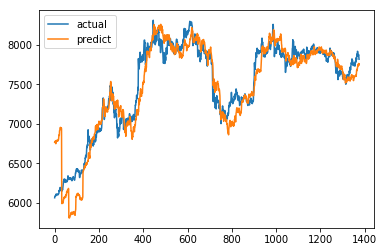

641 / 1375 = 0.4661818181818182


In [16]:
print(test_X.shape)
#print(range(test_X.shape))


#pyplot.plot( inv_y[-100:-1], label='predict')
#pyplot.plot( inv_yhat[-99:], label='actual')
pyplot.plot( inv_y[1:], label='actual')
pyplot.plot( inv_yhat[:-1], label='predict')
pyplot.legend()
pyplot.show()

#涨跌的判准率

#获取预测跟实际对应元素值，是否大于0
a = np.diff(inv_y) > 0
b = np.diff(inv_yhat) > 0

#比较相同值的个数
print(sum(a == b), '/', a.shape[0], '=', sum(a == b)/a.shape[0])

In [17]:
print(test_X)

[[[0.54243565]]

 [[0.5450585 ]]

 [[0.54638827]]

 ...

 [[0.9085047 ]]

 [[0.9123614 ]]

 [[0.9063058 ]]]


In [18]:
print(test_X.shape)
#print(range(test_X.shape))

'''
pyplot.plot( inv_y[-49:], label='actual')
pyplot.plot( inv_yhat[-50:-1], label='predict')
pyplot.legend()
pyplot.show()
'''
#涨跌的判准率

#获取预测跟实际对应元素值，是否大于0
a = np.diff(inv_y) > 0
b = np.diff(inv_yhat) > 0

#比较相同值的个数
print(sum(a == b), '/', a.shape[0], '=', sum(a == b)/a.shape[0])

(1376, 1, 1)
641 / 1375 = 0.4661818181818182


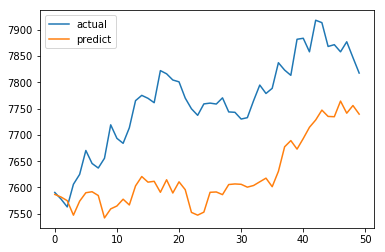

In [19]:
pyplot.plot( inv_y[-50:], label='actual')
pyplot.plot( inv_yhat[-50:], label='predict')
pyplot.legend()
pyplot.show()